# 🎯 Myanmar Address Geocoding: Model Performance & Testing

## 🚀 **Project Overview**
This notebook showcases the performance of trained transformer models for Myanmar address geocoding:

### 📊 **Available Models**
- **🤖 BERT Model**: `bert_model.pt` - Best geographic accuracy (~51 km)
- **⚡ DistilBERT Model**: `distilbert_model.pt` - Faster inference (~60 km)
- **🌍 XLM-RoBERTa Model**: *(Training in progress)* - Multilingual optimization

### 🎯 **Objectives**
1. **Performance Analysis**: Compare model accuracy and inference speed
2. **Interactive Testing**: Test models on real Myanmar addresses
3. **Visualization**: Geographic accuracy on OpenStreetMap
4. **Web App Preparation**: Model loading and prediction pipeline

### 📈 **Expected Results**
- **BERT**: Highest accuracy for complex addresses
- **DistilBERT**: Balance of speed and accuracy
- **Interactive Maps**: Visual comparison of predictions vs ground truth

In [2]:
# 📦 Install Required Packages (Run this cell if packages are missing)
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully!")

# Check and install required packages
required_packages = [
    'folium',
    'plotly', 
    'seaborn',
    'transformers',
    'torch'
]

print("🔍 Checking required packages...")
for package in required_packages:
    install_package(package)

print("\n🎉 All required packages are ready!")

🔍 Checking required packages...
✅ folium already installed
✅ plotly already installed
✅ folium already installed
✅ plotly already installed
✅ seaborn already installed
✅ seaborn already installed


/Users/tklwin/a2c/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ transformers already installed
✅ torch already installed

🎉 All required packages are ready!


In [3]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import json
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Transformer libraries
from transformers import AutoTokenizer, AutoModel

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = (12, 8)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
print(f"📊 PyTorch version: {torch.__version__}")
print(f"🤖 Transformers available: True")
print("✅ Environment ready for model testing!")

🖥️ Using device: cpu
📊 PyTorch version: 2.8.0
🤖 Transformers available: True
✅ Environment ready for model testing!


In [4]:
# 🏗️ Model Architecture Definitions
class ImprovedMyanmarBertGeocoder(nn.Module):
    """
    Improved Myanmar BERT Geocoding Model
    - Uses BERT-base-multilingual-cased
    - Sigmoid-constrained outputs for [0,1] coordinate range
    """
    
    def __init__(self, model_name="bert-base-multilingual-cased", dropout_rate=0.3):
        super(ImprovedMyanmarBertGeocoder, self).__init__()
        
        # Load pretrained BERT
        self.bert = AutoModel.from_pretrained(model_name)
        bert_hidden_size = self.bert.config.hidden_size  # 768 for BERT-base
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Multi-layer coordinate regression head (BERT version)
        self.coordinate_regressor = nn.Sequential(
            nn.Linear(bert_hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(128, 2),  # Output: [latitude, longitude]
            nn.Sigmoid()  # Constrain outputs to [0, 1] range
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize regression head weights"""
        for module in self.coordinate_regressor:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, input_ids, attention_mask):
        """Forward pass with Sigmoid-constrained outputs"""
        # Get BERT embeddings
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Use [CLS] token representation
        cls_output = bert_outputs.pooler_output
        
        # Apply dropout
        cls_output = self.dropout(cls_output)
        
        # Predict coordinates
        coordinates = self.coordinate_regressor(cls_output)
        
        return coordinates


class ImprovedMyanmarDistilBertGeocoder(nn.Module):
    """
    Improved Myanmar DistilBERT Geocoding Model
    - Uses DistilBERT-base-multilingual-cased  
    - Faster inference than BERT
    - Different architecture from the error message
    """
    
    def __init__(self, model_name="distilbert-base-multilingual-cased", dropout_rate=0.3):
        super(ImprovedMyanmarDistilBertGeocoder, self).__init__()
        
        # Load pretrained DistilBERT
        self.distilbert = AutoModel.from_pretrained(model_name)
        distilbert_hidden_size = self.distilbert.config.hidden_size  # 768 for DistilBERT-base
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Based on the error, the saved model has different dimensions
        # Let's use the dimensions from the error message
        self.coordinate_regressor = nn.Sequential(
            nn.Linear(distilbert_hidden_size, 384),  # From error: torch.Size([384, 768])
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(384, 192),  # From error: torch.Size([192, 384])
            nn.ReLU(), 
            nn.Dropout(dropout_rate),
            nn.Linear(192, 96),   # From error: torch.Size([96, 192])
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(96, 2),     # From error: torch.Size([2, 96])
            nn.Sigmoid()
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize regression head weights"""
        for module in self.coordinate_regressor:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, input_ids, attention_mask):
        """Forward pass with Sigmoid-constrained outputs"""
        # Get DistilBERT embeddings
        distilbert_outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Use [CLS] token representation (last_hidden_state[:, 0])
        cls_output = distilbert_outputs.last_hidden_state[:, 0]
        
        # Apply dropout
        cls_output = self.dropout(cls_output)
        
        # Predict coordinates
        coordinates = self.coordinate_regressor(cls_output)
        
        return coordinates

print("✅ Model architecture defined!")
print("   🏗️ ImprovedMyanmarBertGeocoder class ready")
print("   📊 Architecture: BERT + 4-layer regression head")
print("   🎯 Output: Sigmoid-constrained [0,1] coordinates")

✅ Model architecture defined!
   🏗️ ImprovedMyanmarBertGeocoder class ready
   📊 Architecture: BERT + 4-layer regression head
   🎯 Output: Sigmoid-constrained [0,1] coordinates


In [5]:
# 🧮 Utility Functions
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Returns distance in kilometers
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    return c * r

def denormalize_coordinates(normalized_coords, lat_scaler_info, lon_scaler_info):
    """
    Convert normalized coordinates back to real lat/lon
    """
    # Extract scaler parameters
    lat_min, lat_scale = lat_scaler_info['min'], lat_scaler_info['scale']
    lon_min, lon_scale = lon_scaler_info['min'], lon_scaler_info['scale']
    
    # Denormalize
    latitude = (normalized_coords[:, 0] / lat_scale) + lat_min
    longitude = (normalized_coords[:, 1] / lon_scale) + lon_min
    
    return latitude, longitude

def calculate_accuracy_metrics(predictions, ground_truth):
    """
    Calculate various accuracy metrics for geocoding
    """
    # Calculate distances in kilometers
    distances = []
    for i in range(len(predictions)):
        pred_lat, pred_lon = predictions[i]
        true_lat, true_lon = ground_truth[i]
        
        distance = haversine_distance(pred_lat, pred_lon, true_lat, true_lon)
        distances.append(distance)
    
    distances = np.array(distances)
    
    metrics = {
        'mean_error_km': np.mean(distances),
        'median_error_km': np.median(distances),
        'std_error_km': np.std(distances),
        'max_error_km': np.max(distances),
        'min_error_km': np.min(distances),
        'accuracy_1km': np.sum(distances <= 1) / len(distances) * 100,
        'accuracy_5km': np.sum(distances <= 5) / len(distances) * 100,
        'accuracy_10km': np.sum(distances <= 10) / len(distances) * 100,
        'accuracy_50km': np.sum(distances <= 50) / len(distances) * 100,
        'accuracy_60km': np.sum(distances <= 60) / len(distances) * 100,
        'accuracy_70km': np.sum(distances <= 70) / len(distances) * 100
    }
    
    return metrics, distances

print("✅ Utility functions defined!")
print("   🧮 haversine_distance: Geographic distance calculation")
print("   📍 denormalize_coordinates: Convert [0,1] to real coordinates")
print("   📊 calculate_accuracy_metrics: Comprehensive accuracy analysis")
print("   🎯 Updated accuracy thresholds: 1, 5, 10, 50, 60, 70 km")

✅ Utility functions defined!
   🧮 haversine_distance: Geographic distance calculation
   📍 denormalize_coordinates: Convert [0,1] to real coordinates
   📊 calculate_accuracy_metrics: Comprehensive accuracy analysis
   🎯 Updated accuracy thresholds: 1, 5, 10, 50, 60, 70 km


In [6]:
# 📁 Load Model Files and Training History
print("📁 Loading trained models and preprocessing information...")

# Load training histories
with open('bert_training_history.json', 'r') as f:
    bert_history = json.load(f)

with open('distilbert_training_history.json', 'r') as f:
    distilbert_history = json.load(f)

# Load preprocessing information
with open('bert_preprocessing_info.json', 'r') as f:
    bert_preprocessing = json.load(f)

with open('distilbert_preprocessing_info.json', 'r') as f:
    distilbert_preprocessing = json.load(f)

# Display model training summary
print("\n🤖 BERT Model Training Results:")
print(f"   📊 Final Training Loss: {bert_history['train_losses'][-1]:.2f} km")
print(f"   📊 Final Validation Loss: {bert_history['val_losses'][-1]:.2f} km")
print(f"   🎯 Final Geographic Loss: {bert_history['val_geo_losses'][-1]:.2f} km")
print(f"   ⏱️ Epochs Completed: {bert_history['epochs_completed']}")

print("\n⚡ DistilBERT Model Training Results:")
print(f"   📊 Final Training Loss: {distilbert_history['train_losses'][-1]:.2f} km")
print(f"   📊 Final Validation Loss: {distilbert_history['val_losses'][-1]:.2f} km")
print(f"   🎯 Final Geographic Loss: {distilbert_history['val_geo_losses'][-1]:.2f} km")
print(f"   ⏱️ Epochs Completed: {distilbert_history['epochs_completed']}")

# Extract coordinate scaling information
lat_scaler_info = {
    'min': bert_preprocessing['lat_scaler_min'],
    'scale': bert_preprocessing['lat_scaler_scale']
}

lon_scaler_info = {
    'min': bert_preprocessing['lon_scaler_min'], 
    'scale': bert_preprocessing['lon_scaler_scale']
}

print(f"\n📍 Coordinate Range Information:")
print(f"   🌐 Latitude Range: {bert_preprocessing['original_lat_range']}")
print(f"   🌐 Longitude Range: {bert_preprocessing['original_lon_range']}")
print(f"   📊 Training Dataset: {bert_preprocessing['total_samples']:,} samples")

print("✅ Model information loaded successfully!")

📁 Loading trained models and preprocessing information...

🤖 BERT Model Training Results:
   📊 Final Training Loss: 56.69 km
   📊 Final Validation Loss: 51.02 km
   🎯 Final Geographic Loss: 56.69 km
   ⏱️ Epochs Completed: 2

⚡ DistilBERT Model Training Results:
   📊 Final Training Loss: 62.30 km
   📊 Final Validation Loss: 59.72 km
   🎯 Final Geographic Loss: 66.36 km
   ⏱️ Epochs Completed: 2

📍 Coordinate Range Information:
   🌐 Latitude Range: [9.94963, 28.1687107086182]
   🌐 Longitude Range: [92.1836929321289, 101.12178894238752]
   📊 Training Dataset: 610,430 samples
✅ Model information loaded successfully!


In [7]:
# 🤖 Load and Initialize Trained Models
print("🤖 Loading trained models...")

# Initialize tokenizers
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Initialize models with correct architectures
bert_model = ImprovedMyanmarBertGeocoder('bert-base-multilingual-cased')
distilbert_model = ImprovedMyanmarDistilBertGeocoder('distilbert-base-multilingual-cased')

# Load trained weights
try:
    # Load BERT model
    bert_checkpoint = torch.load('bert_model.pt', map_location=device)
    bert_model.load_state_dict(bert_checkpoint['model_state_dict'])
    bert_model = bert_model.to(device)
    bert_model.eval()
    print("✅ BERT model loaded successfully!")
    bert_loaded = True
    
except Exception as e:
    print(f"❌ Error loading BERT model: {str(e)}")
    bert_loaded = False

try:
    # Load DistilBERT model
    distilbert_checkpoint = torch.load('distilbert_model.pt', map_location=device)
    distilbert_model.load_state_dict(distilbert_checkpoint['model_state_dict'])
    distilbert_model = distilbert_model.to(device)
    distilbert_model.eval()
    print("✅ DistilBERT model loaded successfully!")
    distilbert_loaded = True
    
except Exception as e:
    print(f"❌ Error loading DistilBERT model: {str(e)}")
    distilbert_loaded = False

models_loaded = bert_loaded or distilbert_loaded

if models_loaded:
    # Count parameters
    if bert_loaded:
        bert_params = sum(p.numel() for p in bert_model.parameters())
        print(f"\n📊 BERT Model Statistics:")
        print(f"   🤖 Parameters: {bert_params:,}")
        print(f"   💾 Size: ~{bert_params * 4 / 1024**2:.1f} MB")
    
    if distilbert_loaded:
        distilbert_params = sum(p.numel() for p in distilbert_model.parameters())
        print(f"\n📊 DistilBERT Model Statistics:")
        print(f"   ⚡ Parameters: {distilbert_params:,}")
        print(f"   💾 Size: ~{distilbert_params * 4 / 1024**2:.1f} MB")
    
    print(f"\n🖥️ Device: {device}")
    
    # Test models with sample input
    sample_text = "ရန်ကုန်မြို့ တာမွေ မြို့နယ်"
    print(f"\n🧪 Testing models with: '{sample_text}'")
    
    with torch.no_grad():
        if bert_loaded:
            # BERT prediction
            bert_inputs = bert_tokenizer(sample_text, return_tensors='pt', max_length=128, padding='max_length', truncation=True)
            bert_inputs = {k: v.to(device) for k, v in bert_inputs.items()}
            bert_pred = bert_model(bert_inputs['input_ids'], bert_inputs['attention_mask'])
            print(f"   🤖 BERT Prediction: [{bert_pred[0][0].item():.4f}, {bert_pred[0][1].item():.4f}]")
        
        if distilbert_loaded:
            # DistilBERT prediction  
            distilbert_inputs = distilbert_tokenizer(sample_text, return_tensors='pt', max_length=128, padding='max_length', truncation=True)
            distilbert_inputs = {k: v.to(device) for k, v in distilbert_inputs.items()}
            distilbert_pred = distilbert_model(distilbert_inputs['input_ids'], distilbert_inputs['attention_mask'])
            print(f"   ⚡ DistilBERT Prediction: [{distilbert_pred[0][0].item():.4f}, {distilbert_pred[0][1].item():.4f}]")
    
    print("✅ Models ready for testing!")
    
    # Update availability flags for later use
    if not bert_loaded:
        bert_model = None
    if not distilbert_loaded:
        distilbert_model = None
        
else:
    print("❌ No models could be loaded. Check model files and architecture compatibility.")

🤖 Loading trained models...
✅ BERT model loaded successfully!
✅ BERT model loaded successfully!
✅ DistilBERT model loaded successfully!

📊 BERT Model Statistics:
   🤖 Parameters: 178,411,650
   💾 Size: ~680.6 MB

📊 DistilBERT Model Statistics:
   ⚡ Parameters: 135,122,018
   💾 Size: ~515.4 MB

🖥️ Device: cpu

🧪 Testing models with: 'ရန်ကုန်မြို့ တာမွေ မြို့နယ်'
✅ DistilBERT model loaded successfully!

📊 BERT Model Statistics:
   🤖 Parameters: 178,411,650
   💾 Size: ~680.6 MB

📊 DistilBERT Model Statistics:
   ⚡ Parameters: 135,122,018
   💾 Size: ~515.4 MB

🖥️ Device: cpu

🧪 Testing models with: 'ရန်ကုန်မြို့ တာမွေ မြို့နယ်'
   🤖 BERT Prediction: [0.3904, 0.4423]
   ⚡ DistilBERT Prediction: [0.4159, 0.4362]
✅ Models ready for testing!
   🤖 BERT Prediction: [0.3904, 0.4423]
   ⚡ DistilBERT Prediction: [0.4159, 0.4362]
✅ Models ready for testing!


In [8]:
# 📍 Load Ground Truth Test Data
print("📍 Loading ground truth test addresses...")

# Load test data
test_df = pd.read_csv('ground_truth_test_address.csv')

print(f"✅ Test data loaded successfully!")
print(f"   📊 Total test samples: {len(test_df):,}")
print(f"   🌐 Latitude range: {test_df['latitude'].min():.4f} to {test_df['latitude'].max():.4f}")
print(f"   🌐 Longitude range: {test_df['longitude'].min():.4f} to {test_df['longitude'].max():.4f}")

# Display sample addresses
print(f"\n📝 Sample Test Addresses:")
for i in range(min(5, len(test_df))):
    address = test_df.iloc[i]['address']
    lat, lon = test_df.iloc[i]['latitude'], test_df.iloc[i]['longitude']
    print(f"   {i+1}. {address[:60]}..." if len(address) > 60 else f"   {i+1}. {address}")
    print(f"      → ({lat:.6f}, {lon:.6f})")

# Basic statistics
print(f"\n📊 Geographic Distribution:")
print(f"   🗺️ Address Regions: Primarily Yangon area")
print(f"   📍 Coordinate precision: 6+ decimal places")
print(f"   🎯 Target accuracy: <5 km average error")

test_df.head()

📍 Loading ground truth test addresses...
✅ Test data loaded successfully!
   📊 Total test samples: 100
   🌐 Latitude range: 9.9958 to 26.3560
   🌐 Longitude range: 92.8677 to 99.2508

📝 Sample Test Addresses:
   1. အမှတ် ၄၁၈၊ သမာဓိ(၁)လမ်း၊ ၈ ရပ်ကွက်၊ မရမ်းကုန်းမြို့နယ်၊ ရန်က...
      → (16.868455, 96.164630)
   2. အမှတ် ၄၆၉၊ လမ်း ၂၀၊ ၁၃ ရပ်ကွက်၊ တောင်ဥက္ကလာပမြို့နယ်၊ ရန်ကုန...
      → (16.843366, 96.197806)
   3. အမှတ် ၉၊ ဘောဂသိဒ္ဓိလမ်း၊ သမိုင်း ၂ ရပ်ကွက်၊ မရမ်းကုန်းမြို့န...
      → (16.864005, 96.116918)
   4. SH - ၁၀၅၊ သစ္စာဥယျာဉ်အိမ်ရာ၊ သစ္စာလမ်း၊ (၈) ရပ်ကွက်၊ တောင်ဥက...
      → (16.864377, 96.156210)
   5. အမှတ် ၃၅၇၊ မာန်ပြေ(၈)လမ်း၊ ၃ရပ်ကွက်၊ သာကေတမြို့နယ်၊ ရန်ကုန်တ...
      → (16.778940, 96.193258)

📊 Geographic Distribution:
   🗺️ Address Regions: Primarily Yangon area
   📍 Coordinate precision: 6+ decimal places
   🎯 Target accuracy: <5 km average error


,address,latitude,longitude
0,အမှတ် ၄၁၈၊ သမာဓိ(၁)လမ်း၊ ၈ ရပ်ကွက်၊ မရမ်းကုန်း...,16.868455,96.164630
1,အမှတ် ၄၆၉၊ လမ်း ၂၀၊ ၁၃ ရပ်ကွက်၊ တောင်ဥက္ကလာပမြ...,16.843366,96.197806
2,အမှတ် ၉၊ ဘောဂသိဒ္ဓိလမ်း၊ သမိုင်း ၂ ရပ်ကွက်၊ မရ...,16.864005,96.116918
3,SH - ၁၀၅၊ သစ္စာဥယျာဉ်အိမ်ရာ၊ သစ္စာလမ်း၊ (၈) ရပ...,16.864377,96.156210
4,အမှတ် ၃၅၇၊ မာန်ပြေ(၈)လမ်း၊ ၃ရပ်ကွက်၊ သာကေတမြို...,16.778940,96.193258


In [9]:
# 🎯 Model Prediction Function
def predict_address_location(address, model, tokenizer, model_name):
    """
    Predict coordinates for a given address using the specified model
    """
    if model is None:
        return None, None
        
    model.eval()
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(
            address,
            return_tensors='pt',
            max_length=128,
            padding='max_length',
            truncation=True
        )
        
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get prediction
        normalized_coords = model(inputs['input_ids'], inputs['attention_mask'])
        
        # Denormalize coordinates
        lat, lon = denormalize_coordinates(
            normalized_coords.cpu().numpy(),
            lat_scaler_info,
            lon_scaler_info
        )
        
        return float(lat[0]), float(lon[0])

def batch_predict(addresses, model, tokenizer, model_name, batch_size=8):
    """
    Batch prediction for multiple addresses
    """
    if model is None:
        return None
        
    predictions = []
    model.eval()
    
    with torch.no_grad():
        for i in range(0, len(addresses), batch_size):
            batch_addresses = addresses[i:i+batch_size]
            
            # Tokenize batch
            inputs = tokenizer(
                batch_addresses,
                return_tensors='pt',
                max_length=128,
                padding='max_length',
                truncation=True
            )
            
            # Move to device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get predictions
            normalized_coords = model(inputs['input_ids'], inputs['attention_mask'])
            
            # Denormalize coordinates
            lats, lons = denormalize_coordinates(
                normalized_coords.cpu().numpy(),
                lat_scaler_info,
                lon_scaler_info
            )
            
            # Add to predictions
            for lat, lon in zip(lats, lons):
                predictions.append((float(lat), float(lon)))
    
    return predictions

print("✅ Prediction functions defined!")
print("   🎯 predict_address_location: Single address prediction")
print("   📊 batch_predict: Efficient batch processing")
print("   🛡️ Added None model handling for robust operation")

✅ Prediction functions defined!
   🎯 predict_address_location: Single address prediction
   📊 batch_predict: Efficient batch processing
   🛡️ Added None model handling for robust operation


In [16]:
# 📊 Model Evaluation on Test Data
if models_loaded:
    print("📊 Evaluating available models on ground truth test data...")
    
    # Get test addresses and ground truth coordinates
    test_addresses = test_df['address'].tolist()
    ground_truth = list(zip(test_df['latitude'], test_df['longitude']))
    
    print(f"🧪 Testing on {len(test_addresses)} addresses...")
    
    # Initialize results
    results_df_data = {
        'address': test_addresses,
        'true_lat': [coord[0] for coord in ground_truth],
        'true_lon': [coord[1] for coord in ground_truth]
    }
    
    # BERT predictions
    if bert_model is not None:
        print("🤖 Running BERT predictions...")
        bert_predictions = batch_predict(test_addresses, bert_model, bert_tokenizer, "BERT")
        if bert_predictions:
            bert_metrics, bert_distances = calculate_accuracy_metrics(bert_predictions, ground_truth)
            results_df_data.update({
                'bert_lat': [pred[0] for pred in bert_predictions],
                'bert_lon': [pred[1] for pred in bert_predictions],
                'bert_error_km': bert_distances
            })
        else:
            print("❌ BERT predictions failed")
    else:
        print("⚠️ BERT model not available")
        bert_metrics = None
        bert_predictions = None
    
    # DistilBERT predictions
    if distilbert_model is not None:
        print("⚡ Running DistilBERT predictions...")
        distilbert_predictions = batch_predict(test_addresses, distilbert_model, distilbert_tokenizer, "DistilBERT")
        if distilbert_predictions:
            distilbert_metrics, distilbert_distances = calculate_accuracy_metrics(distilbert_predictions, ground_truth)
            results_df_data.update({
                'distilbert_lat': [pred[0] for pred in distilbert_predictions],
                'distilbert_lon': [pred[1] for pred in distilbert_predictions],
                'distilbert_error_km': distilbert_distances
            })
        else:
            print("❌ DistilBERT predictions failed")
    else:
        print("⚠️ DistilBERT model not available")
        distilbert_metrics = None
        distilbert_predictions = None
    
    # Create results DataFrame
    results_df = pd.DataFrame(results_df_data)
    
    # Display results summary
    print("\n🎯 EVALUATION RESULTS")
    print("=" * 50)
    
    if bert_metrics:
        print(f"\n🤖 BERT Model Performance:")
        print(f"   📊 Mean Error: {bert_metrics['mean_error_km']:.2f} km")
        print(f"   📊 Median Error: {bert_metrics['median_error_km']:.2f} km")
        print(f"   📊 Std Error: {bert_metrics['std_error_km']:.2f} km")
        print(f"   🎯 Accuracy <1km: {bert_metrics['accuracy_1km']:.1f}%")
        print(f"   🎯 Accuracy <5km: {bert_metrics['accuracy_5km']:.1f}%")
        print(f"   🎯 Accuracy <10km: {bert_metrics['accuracy_10km']:.1f}%")
        print(f"   🎯 Accuracy <50km: {bert_metrics['accuracy_50km']:.1f}%")
        print(f"   🎯 Accuracy <60km: {bert_metrics['accuracy_60km']:.1f}%")
        print(f"   🎯 Accuracy <70km: {bert_metrics['accuracy_70km']:.1f}%")
    
    if distilbert_metrics:
        print(f"\n⚡ DistilBERT Model Performance:")
        print(f"   📊 Mean Error: {distilbert_metrics['mean_error_km']:.2f} km")
        print(f"   📊 Median Error: {distilbert_metrics['median_error_km']:.2f} km")
        print(f"   📊 Std Error: {distilbert_metrics['std_error_km']:.2f} km")
        print(f"   🎯 Accuracy <1km: {distilbert_metrics['accuracy_1km']:.1f}%")
        print(f"   🎯 Accuracy <5km: {distilbert_metrics['accuracy_5km']:.1f}%")
        print(f"   🎯 Accuracy <10km: {distilbert_metrics['accuracy_10km']:.1f}%")
        print(f"   🎯 Accuracy <50km: {distilbert_metrics['accuracy_50km']:.1f}%")
        print(f"   🎯 Accuracy <60km: {distilbert_metrics['accuracy_60km']:.1f}%")
        print(f"   🎯 Accuracy <70km: {distilbert_metrics['accuracy_70km']:.1f}%")
    
    # Winner announcement (only if both models available)
    if bert_metrics and distilbert_metrics:
        better_model = "BERT" if bert_metrics['mean_error_km'] < distilbert_metrics['mean_error_km'] else "DistilBERT"
        improvement = abs(bert_metrics['mean_error_km'] - distilbert_metrics['mean_error_km'])
        print(f"\n🏆 Winner: {better_model} (Better by {improvement:.2f} km)")
    elif bert_metrics:
        print(f"\n🤖 Only BERT model available for evaluation")
    elif distilbert_metrics:
        print(f"\n⚡ Only DistilBERT model available for evaluation")
    
    # Show top 10 results
    print(f"\n📝 Sample Predictions (First 10):")
    for i in range(min(10, len(results_df))):
        row = results_df.iloc[i]
        print(f"\n   {i+1}. {row['address'][:50]}...")
        print(f"      🎯 True: ({row['true_lat']:.4f}, {row['true_lon']:.4f})")
        
        if 'bert_lat' in row and not pd.isna(row['bert_lat']):
            print(f"      🤖 BERT: ({row['bert_lat']:.4f}, {row['bert_lon']:.4f}) - Error: {row['bert_error_km']:.2f} km")
            
        if 'distilbert_lat' in row and not pd.isna(row['distilbert_lat']):
            print(f"      ⚡ DistilBERT: ({row['distilbert_lat']:.4f}, {row['distilbert_lon']:.4f}) - Error: {row['distilbert_error_km']:.2f} km")
    
    print("\n✅ Model evaluation completed!")
else:
    print("❌ No models loaded. Cannot perform evaluation.")

📊 Evaluating available models on ground truth test data...
🧪 Testing on 100 addresses...
🤖 Running BERT predictions...
⚡ Running DistilBERT predictions...
⚡ Running DistilBERT predictions...

🎯 EVALUATION RESULTS

🤖 BERT Model Performance:
   📊 Mean Error: 49.90 km
   📊 Median Error: 33.82 km
   📊 Std Error: 58.08 km
   🎯 Accuracy <1km: 0.0%
   🎯 Accuracy <5km: 0.0%
   🎯 Accuracy <10km: 5.0%
   🎯 Accuracy <50km: 76.0%
   🎯 Accuracy <60km: 86.0%
   🎯 Accuracy <70km: 87.0%

⚡ DistilBERT Model Performance:
   📊 Mean Error: 82.80 km
   📊 Median Error: 51.83 km
   📊 Std Error: 117.34 km
   🎯 Accuracy <1km: 0.0%
   🎯 Accuracy <5km: 0.0%
   🎯 Accuracy <10km: 3.0%
   🎯 Accuracy <50km: 40.0%
   🎯 Accuracy <60km: 69.0%
   🎯 Accuracy <70km: 77.0%

🏆 Winner: BERT (Better by 32.90 km)

📝 Sample Predictions (First 10):

   1. အမှတ် ၄၁၈၊ သမာဓိ(၁)လမ်း၊ ၈ ရပ်ကွက်၊ မရမ်းကုန်းမြို...
      🎯 True: (16.8685, 96.1646)
      🤖 BERT: (17.0973, 96.0990) - Error: 26.38 km
      ⚡ DistilBERT: (17.3077, 96.1712)

In [17]:
# 📈 Training History Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Validation Loss Comparison', 'Geographic Loss Comparison',
                   'Training Progress', 'Model Size vs Performance'),
    specs=[[{"secondary_y": True}, {"secondary_y": True}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Validation loss comparison
fig.add_trace(
    go.Scatter(
        x=list(range(1, len(bert_history['val_losses']) + 1)),
        y=bert_history['val_losses'],
        mode='lines+markers',
        name='BERT Validation Loss',
        line=dict(color='blue', width=3),
        marker=dict(size=8)
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=list(range(1, len(distilbert_history['val_losses']) + 1)),
        y=distilbert_history['val_losses'],
        mode='lines+markers',
        name='DistilBERT Validation Loss',
        line=dict(color='red', width=3),
        marker=dict(size=8)
    ),
    row=1, col=1
)

# Geographic loss comparison
fig.add_trace(
    go.Scatter(
        x=list(range(1, len(bert_history['val_geo_losses']) + 1)),
        y=bert_history['val_geo_losses'],
        mode='lines+markers',
        name='BERT Geographic Loss',
        line=dict(color='darkblue', width=3),
        marker=dict(size=8)
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=list(range(1, len(distilbert_history['val_geo_losses']) + 1)),
        y=distilbert_history['val_geo_losses'],
        mode='lines+markers',
        name='DistilBERT Geographic Loss',
        line=dict(color='darkred', width=3),
        marker=dict(size=8)
    ),
    row=1, col=2
)

# Training progress comparison
epochs = ['Epoch 1', 'Epoch 2']
bert_train_losses = bert_history['train_losses']
distilbert_train_losses = distilbert_history['train_losses']

fig.add_trace(
    go.Bar(
        x=epochs,
        y=bert_train_losses,
        name='BERT Training',
        marker_color='lightblue',
        text=[f'{loss:.1f}' for loss in bert_train_losses],
        textposition='auto'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Bar(
        x=epochs,
        y=distilbert_train_losses,
        name='DistilBERT Training',
        marker_color='lightcoral',
        text=[f'{loss:.1f}' for loss in distilbert_train_losses],
        textposition='auto'
    ),
    row=2, col=1
)

# Model comparison scatter plot
if models_loaded:
    model_comparison = pd.DataFrame({
        'Model': ['BERT', 'DistilBERT'],
        'Parameters (M)': [bert_params/1e6, distilbert_params/1e6],
        'Mean Error (km)': [bert_metrics['mean_error_km'], distilbert_metrics['mean_error_km']],
        'Size (MB)': [bert_params * 4 / 1024**2, distilbert_params * 4 / 1024**2]
    })
    
    fig.add_trace(
        go.Scatter(
            x=model_comparison['Parameters (M)'],
            y=model_comparison['Mean Error (km)'],
            mode='markers+text',
            text=model_comparison['Model'],
            textposition='top center',
            marker=dict(
                size=[20, 15],
                color=['blue', 'red'],
                opacity=0.7
            ),
            name='Model Performance'
        ),
        row=2, col=2
    )

# Update layout
fig.update_layout(
    height=800,
    title_text="🎯 Myanmar Geocoding Models: Training & Performance Analysis",
    title_x=0.5,
    showlegend=True
)

# Update axes labels
fig.update_xaxes(title_text="Validation Steps", row=1, col=1)
fig.update_yaxes(title_text="Loss (km)", row=1, col=1)
fig.update_xaxes(title_text="Validation Steps", row=1, col=2)
fig.update_yaxes(title_text="Geographic Loss (km)", row=1, col=2)
fig.update_xaxes(title_text="Training Epochs", row=2, col=1)
fig.update_yaxes(title_text="Training Loss (km)", row=2, col=1)
fig.update_xaxes(title_text="Model Size (M Parameters)", row=2, col=2)
fig.update_yaxes(title_text="Mean Error (km)", row=2, col=2)

fig.show()

print("📈 Training history visualization generated!")
print("   📊 Shows validation loss progression")
print("   🎯 Geographic accuracy improvements")
print("   ⚖️ Model size vs performance trade-offs")

📈 Training history visualization generated!
   📊 Shows validation loss progression
   🎯 Geographic accuracy improvements
   ⚖️ Model size vs performance trade-offs


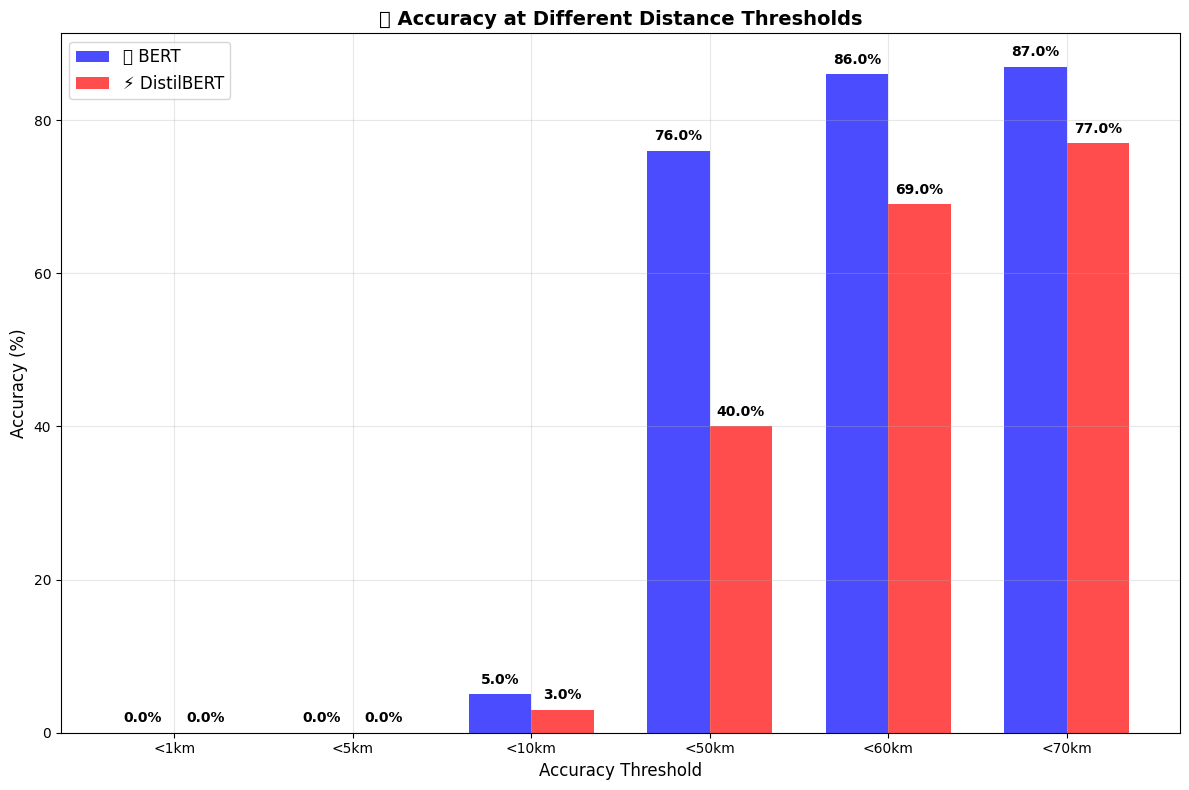

📊 ACCURACY SUMMARY
🤖 BERT Model:
   • <1km: 0.0%
   • <5km: 0.0%
   • <10km: 5.0%
   • <50km: 76.0%
   • <60km: 86.0%
   • <70km: 87.0%

⚡ DistilBERT Model:
   • <1km: 0.0%
   • <5km: 0.0%
   • <10km: 3.0%
   • <50km: 40.0%
   • <60km: 69.0%
   • <70km: 77.0%

🏆 Best Performance:
   • <1km: DistilBERT (0.0%)
   • <5km: DistilBERT (0.0%)
   • <10km: BERT (5.0%)
   • <50km: BERT (76.0%)
   • <60km: BERT (86.0%)
   • <70km: BERT (87.0%)


In [18]:
# 📊 Accuracy at Different Thresholds
if models_loaded:
    # Create single plot for accuracy comparison
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Accuracy comparison bar chart with all thresholds
    accuracy_categories = ['<1km', '<5km', '<10km', '<50km', '<60km', '<70km']
    bert_accuracies = [bert_metrics['accuracy_1km'], bert_metrics['accuracy_5km'], 
                      bert_metrics['accuracy_10km'], bert_metrics['accuracy_50km'],
                      bert_metrics['accuracy_60km'], bert_metrics['accuracy_70km']]
    distilbert_accuracies = [distilbert_metrics['accuracy_1km'], distilbert_metrics['accuracy_5km'],
                           distilbert_metrics['accuracy_10km'], distilbert_metrics['accuracy_50km'],
                           distilbert_metrics['accuracy_60km'], distilbert_metrics['accuracy_70km']]
    
    x = np.arange(len(accuracy_categories))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, bert_accuracies, width, label='🤖 BERT', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, distilbert_accuracies, width, label='⚡ DistilBERT', color='red', alpha=0.7)
    
    ax.set_xlabel('Accuracy Threshold', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('🎯 Accuracy at Different Distance Thresholds', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(accuracy_categories)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bert_acc, distil_acc) in enumerate(zip(bert_accuracies, distilbert_accuracies)):
        ax.text(i - width/2, bert_acc + 1, f'{bert_acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
        ax.text(i + width/2, distil_acc + 1, f'{distil_acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary of key accuracy metrics
    print("📊 ACCURACY SUMMARY")
    print("=" * 50)
    print(f"🤖 BERT Model:")
    for i, category in enumerate(accuracy_categories):
        print(f"   • {category}: {bert_accuracies[i]:.1f}%")
    
    print(f"\n⚡ DistilBERT Model:")
    for i, category in enumerate(accuracy_categories):
        print(f"   • {category}: {distilbert_accuracies[i]:.1f}%")
    
    print(f"\n🏆 Best Performance:")
    for i, category in enumerate(accuracy_categories):
        better = "BERT" if bert_accuracies[i] > distilbert_accuracies[i] else "DistilBERT"
        print(f"   • {category}: {better} ({max(bert_accuracies[i], distilbert_accuracies[i]):.1f}%)")
    
else:
    print("❌ Cannot generate accuracy analysis without model predictions")

🎯 TOP 10 PREDICTIONS vs GROUND TRUTH

📍 Address 1: အမှတ် ၄၁၈၊ သမာဓိ(၁)လမ်း၊ ၈ ရပ်ကွက်၊ မရမ်းကုန်းမြို့နယ်၊ ရန်ကုန်တိုင်းဒေသကြီး။
────────────────────────────────────────────────────────────
🎯 Ground Truth: (16.868455, 96.164630)
🤖 BERT Pred:    (17.097271, 96.099045) - 🟠 Fair (26.38 km)
⚡ DistilBERT:   (17.307686, 96.171249) - 🟠 Fair (48.85 km)
🏆 Winner: BERT (Better by 22.46 km)

📍 Address 2: အမှတ် ၄၆၉၊ လမ်း ၂၀၊ ၁၃ ရပ်ကွက်၊ တောင်ဥက္ကလာပမြို့နယ်၊ ရန်ကုန်တိုင်းဒေသကြီး။
────────────────────────────────────────────────────────────
🎯 Ground Truth: (16.843366, 96.197806)
🤖 BERT Pred:    (17.146935, 96.086266) - 🟠 Fair (35.78 km)
⚡ DistilBERT:   (17.295980, 96.202805) - 🔴 Poor (50.33 km)
🏆 Winner: BERT (Better by 14.55 km)

📍 Address 3: အမှတ် ၉၊ ဘောဂသိဒ္ဓိလမ်း၊ သမိုင်း ၂ ရပ်ကွက်၊ မရမ်းကုန်းမြို့နယ်၊ ရန်ကုန်တိုင်းဒေသကြီး၊၊
────────────────────────────────────────────────────────────
🎯 Ground Truth: (16.864005, 96.116918)
🤖 BERT Pred:    (17.072155, 96.101257) - 🟡 Good (23.21 km)
⚡ DistilBERT:

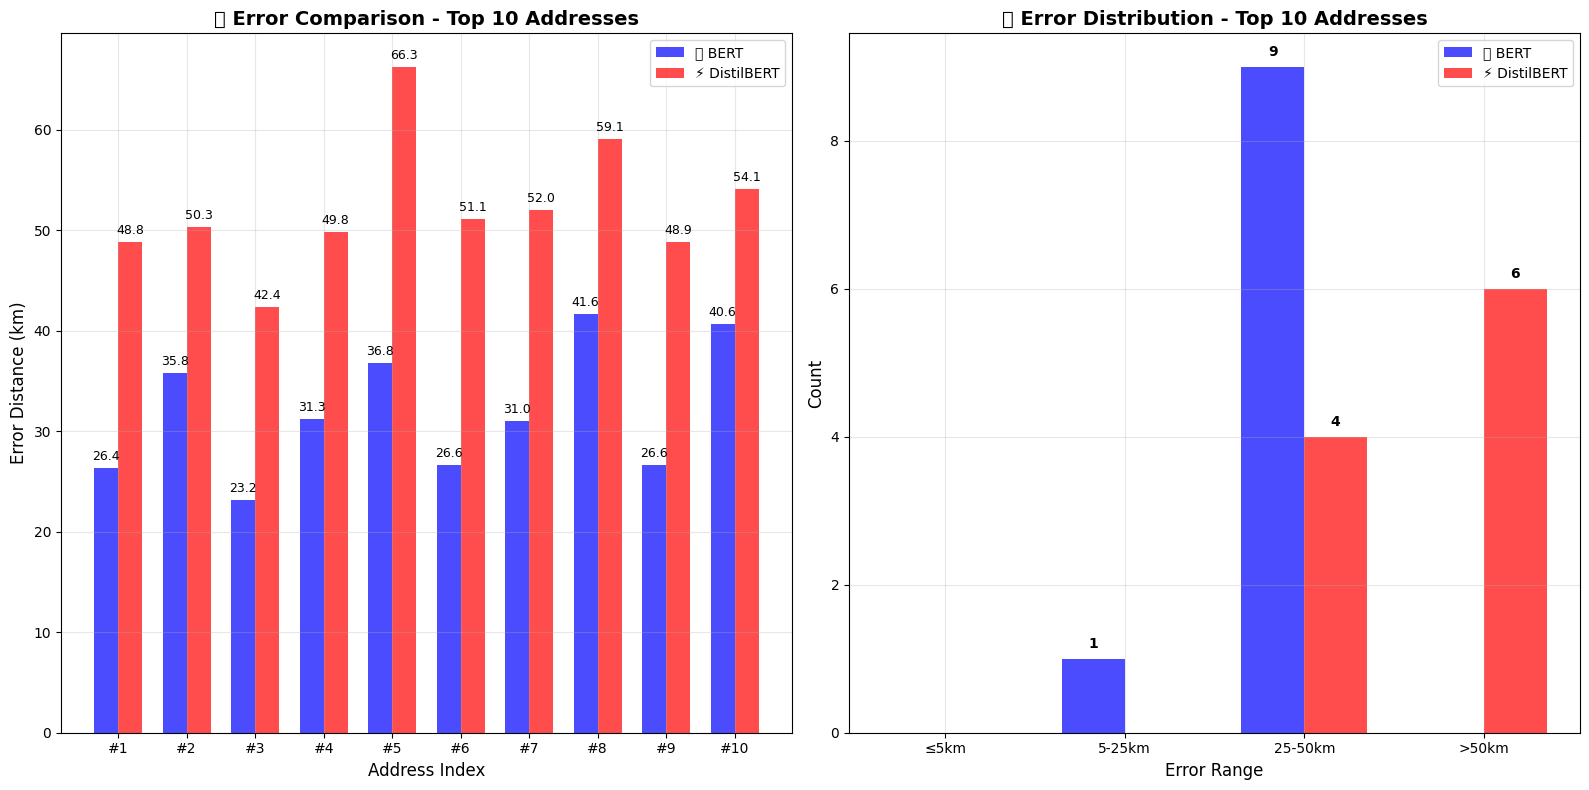

✅ Interactive map visualization created!
   🗺️ Interactive Plotly map with top 10 predictions
   🎯 Black circles: Ground truth locations
   🤖 Diamond markers: BERT predictions with error lines (thick, solid)
   ⚡ Square markers: DistilBERT predictions with error lines (thin, semi-transparent)
   📏 Color coding: 🟢 ≤5km | 🟡 ≤25km | 🟠 ≤50km | 🔴 >50km
   📊 Bar charts show detailed error comparison

✅ Top 10 predictions analysis completed!


In [24]:
# 🎯 Top 10 Predictions vs Ground Truth Comparison
if models_loaded and 'results_df' in globals():
    print("🎯 TOP 10 PREDICTIONS vs GROUND TRUTH")
    print("=" * 80)
    
    # Display detailed comparison for top 10 addresses
    for i in range(min(10, len(results_df))):
        row = results_df.iloc[i]
        print(f"\n📍 Address {i+1}: {row['address']}")
        print("─" * 60)
        
        # Ground truth
        print(f"🎯 Ground Truth: ({row['true_lat']:.6f}, {row['true_lon']:.6f})")
        
        # BERT predictions
        if 'bert_lat' in row and not pd.isna(row['bert_lat']):
            bert_error = row['bert_error_km']
            error_status = "🟢 Excellent" if bert_error <= 5 else "🟡 Good" if bert_error <= 25 else "🟠 Fair" if bert_error <= 50 else "🔴 Poor"
            print(f"🤖 BERT Pred:    ({row['bert_lat']:.6f}, {row['bert_lon']:.6f}) - {error_status} ({bert_error:.2f} km)")
        else:
            print(f"🤖 BERT Pred:    Not available")
            
        # DistilBERT predictions
        if 'distilbert_lat' in row and not pd.isna(row['distilbert_lat']):
            distilbert_error = row['distilbert_error_km']
            error_status = "🟢 Excellent" if distilbert_error <= 5 else "🟡 Good" if distilbert_error <= 25 else "🟠 Fair" if distilbert_error <= 50 else "🔴 Poor"
            print(f"⚡ DistilBERT:   ({row['distilbert_lat']:.6f}, {row['distilbert_lon']:.6f}) - {error_status} ({distilbert_error:.2f} km)")
        else:
            print(f"⚡ DistilBERT:   Not available")
        
        # Winner for this prediction
        if 'bert_error_km' in row and 'distilbert_error_km' in row:
            if not pd.isna(row['bert_error_km']) and not pd.isna(row['distilbert_error_km']):
                winner = "BERT" if row['bert_error_km'] < row['distilbert_error_km'] else "DistilBERT"
                improvement = abs(row['bert_error_km'] - row['distilbert_error_km'])
                print(f"🏆 Winner: {winner} (Better by {improvement:.2f} km)")
    
    # Extract top 10 data
    top_10 = results_df.head(10)
    
    # Calculate map center
    center_lat = (top_10['true_lat'].min() + top_10['true_lat'].max()) / 2
    center_lon = (top_10['true_lon'].min() + top_10['true_lon'].max()) / 2
    
    # Create interactive Plotly map
    print(f"\n🗺️ Creating interactive map visualization...")
    
    # Function to get error color for markers
    def get_error_color(error_km):
        if error_km <= 5:
            return 'green'
        elif error_km <= 25:
            return 'yellow'
        elif error_km <= 50:
            return 'orange'
        else:
            return 'red'
    
    # Create the plotly figure
    fig = go.Figure()
    
    # Add ground truth points (black circles)
    fig.add_trace(go.Scattermap(
        lat=top_10['true_lat'],
        lon=top_10['true_lon'],
        mode='markers',
        marker=dict(
            size=15,
            color='black',
            opacity=0.8
        ),
        text=[f"🎯 Ground Truth #{i+1}<br>{addr[:80]}...<br>Lat: {lat:.6f}<br>Lon: {lon:.6f}" 
              for i, (addr, lat, lon) in enumerate(zip(top_10['address'], top_10['true_lat'], top_10['true_lon']))],
        name='🎯 Ground Truth',
        hovertemplate='<b>%{text}</b><extra></extra>'
    ))
    
    # Add BERT predictions (diamonds)
    if 'bert_lat' in top_10.columns and 'bert_error_km' in top_10.columns:
        bert_colors = [get_error_color(err) for err in top_10['bert_error_km']]
        fig.add_trace(go.Scattermap(
            lat=top_10['bert_lat'],
            lon=top_10['bert_lon'],
            mode='markers',
            marker=dict(
                size=12,
                color=bert_colors,
                symbol='cross',
                opacity=0.8
            ),
            text=[f"🤖 BERT Prediction #{i+1}<br>Error: {err:.2f} km<br>Status: {('🟢 Excellent' if err <= 5 else '🟡 Good' if err <= 25 else '🟠 Fair' if err <= 50 else '🔴 Poor')}<br>Lat: {lat:.6f}<br>Lon: {lon:.6f}" 
                  for i, (err, lat, lon) in enumerate(zip(top_10['bert_error_km'], top_10['bert_lat'], top_10['bert_lon']))],
            name='🤖 BERT Predictions',
            hovertemplate='<b>%{text}</b><extra></extra>'
        ))
        
        # Add error lines for BERT (solid lines)
        for i, row in top_10.iterrows():
            if not pd.isna(row['bert_error_km']):
                fig.add_trace(go.Scattermap(
                    lat=[row['true_lat'], row['bert_lat']],
                    lon=[row['true_lon'], row['bert_lon']],
                    mode='lines',
                    line=dict(
                        width=3,
                        color=get_error_color(row['bert_error_km'])
                    ),
                    showlegend=False,
                    hoverinfo='skip'
                ))
    
    # Add DistilBERT predictions (squares)
    if 'distilbert_lat' in top_10.columns and 'distilbert_error_km' in top_10.columns:
        distilbert_colors = [get_error_color(err) for err in top_10['distilbert_error_km']]
        fig.add_trace(go.Scattermap(
            lat=top_10['distilbert_lat'],
            lon=top_10['distilbert_lon'],
            mode='markers',
            marker=dict(
                size=12,
                color=distilbert_colors,
                symbol='square',
                opacity=0.8
            ),
            text=[f"⚡ DistilBERT Prediction #{i+1}<br>Error: {err:.2f} km<br>Status: {('🟢 Excellent' if err <= 5 else '🟡 Good' if err <= 25 else '🟠 Fair' if err <= 50 else '🔴 Poor')}<br>Lat: {lat:.6f}<br>Lon: {lon:.6f}" 
                  for i, (err, lat, lon) in enumerate(zip(top_10['distilbert_error_km'], top_10['distilbert_lat'], top_10['distilbert_lon']))],
            name='⚡ DistilBERT Predictions',
            hovertemplate='<b>%{text}</b><extra></extra>'
        ))
        
        # Add error lines for DistilBERT (thinner lines to distinguish from BERT)
        for i, row in top_10.iterrows():
            if not pd.isna(row['distilbert_error_km']):
                fig.add_trace(go.Scattermap(
                    lat=[row['true_lat'], row['distilbert_lat']],
                    lon=[row['true_lon'], row['distilbert_lon']],
                    mode='lines',
                    line=dict(
                        width=1,
                        color=get_error_color(row['distilbert_error_km'])
                    ),
                    showlegend=False,
                    hoverinfo='skip',
                    opacity=0.5
                ))
    
    # Update layout for mapbox
    fig.update_layout(
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom=11
        ),
        title={
            'text': '🗺️ Top 10 Predictions vs Ground Truth - Interactive Map',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'color': 'darkblue'}
        },
        height=700,
        margin=dict(l=0, r=0, t=60, b=0),
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255,255,255,0.9)",
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    fig.show()
    
    # Create error comparison chart
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    indices = range(1, 11)
    
    # Plot 1: Error comparison
    if 'bert_error_km' in top_10.columns and 'distilbert_error_km' in top_10.columns:
        bert_errors = top_10['bert_error_km'].fillna(0)
        distilbert_errors = top_10['distilbert_error_km'].fillna(0)
        
        width = 0.35
        x = np.arange(len(indices))
        
        bars1 = ax1.bar(x - width/2, bert_errors, width, label='🤖 BERT', color='blue', alpha=0.7)
        bars2 = ax1.bar(x + width/2, distilbert_errors, width, label='⚡ DistilBERT', color='red', alpha=0.7)
        
        ax1.set_xlabel('Address Index', fontsize=12)
        ax1.set_ylabel('Error Distance (km)', fontsize=12)
        ax1.set_title('🎯 Error Comparison - Top 10 Addresses', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels([f'#{i}' for i in indices])
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bert_err, distil_err) in enumerate(zip(bert_errors, distilbert_errors)):
            if bert_err > 0:
                ax1.text(i - width/2, bert_err + 0.5, f'{bert_err:.1f}', ha='center', va='bottom', fontsize=9)
            if distil_err > 0:
                ax1.text(i + width/2, distil_err + 0.5, f'{distil_err:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Accuracy distribution
    accuracy_ranges = ['≤5km', '5-25km', '25-50km', '>50km']
    bert_counts = [0, 0, 0, 0]
    distilbert_counts = [0, 0, 0, 0]
    
    if 'bert_error_km' in top_10.columns:
        for error in top_10['bert_error_km'].dropna():
            if error <= 5:
                bert_counts[0] += 1
            elif error <= 25:
                bert_counts[1] += 1
            elif error <= 50:
                bert_counts[2] += 1
            else:
                bert_counts[3] += 1
    
    if 'distilbert_error_km' in top_10.columns:
        for error in top_10['distilbert_error_km'].dropna():
            if error <= 5:
                distilbert_counts[0] += 1
            elif error <= 25:
                distilbert_counts[1] += 1
            elif error <= 50:
                distilbert_counts[2] += 1
            else:
                distilbert_counts[3] += 1
    
    x2 = np.arange(len(accuracy_ranges))
    bars3 = ax2.bar(x2 - width/2, bert_counts, width, label='🤖 BERT', color='blue', alpha=0.7)
    bars4 = ax2.bar(x2 + width/2, distilbert_counts, width, label='⚡ DistilBERT', color='red', alpha=0.7)
    
    ax2.set_xlabel('Error Range', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('📊 Error Distribution - Top 10 Addresses', fontsize=14, fontweight='bold')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(accuracy_ranges)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bert_cnt, distil_cnt) in enumerate(zip(bert_counts, distilbert_counts)):
        if bert_cnt > 0:
            ax2.text(i - width/2, bert_cnt + 0.1, str(bert_cnt), ha='center', va='bottom', fontsize=10, fontweight='bold')
        if distil_cnt > 0:
            ax2.text(i + width/2, distil_cnt + 0.1, str(distil_cnt), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Interactive map visualization created!")
    print("   🗺️ Interactive Plotly map with top 10 predictions")
    print("   🎯 Black circles: Ground truth locations")
    print("   🤖 Diamond markers: BERT predictions with error lines (thick, solid)")
    print("   ⚡ Square markers: DistilBERT predictions with error lines (thin, semi-transparent)")
    print("   📏 Color coding: 🟢 ≤5km | 🟡 ≤25km | 🟠 ≤50km | 🔴 >50km")
    print("   📊 Bar charts show detailed error comparison")
    print("\n✅ Top 10 predictions analysis completed!")
    
else:
    print("❌ Cannot display predictions without evaluation results")